# Advanced Assessment

Data Source **https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository/data**

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import warnings
from utils.anomalies_helpers import update_plot_with_anomalies

# ignore all warnings
warnings.filterwarnings("ignore")

from utils.eda_helpers import get_location_dropdown, get_country_dropdown, eda_update_plot, get_field_dropdown

In [31]:
# read the csv data 
data = pd.read_csv('data/GlobalWeatherRepository_filtered.csv')
data.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


**Advanced EDA** <br> Anomaly detection to identify and analyze outliers.


In [32]:
# convery the last_updated column to datetime
data['last_updated'] = pd.to_datetime(data['last_updated'])

In [33]:
# Update location dropdown based on country selection
# Define dropdowns
country_dropdown = get_country_dropdown(data)

location_dropdown = get_location_dropdown(data)

field_dropdown = get_field_dropdown(data)

# Update location dropdown based on country selection
def update_location_dropdown(change):
    selected_country = change['new']
    locations = data[data['country'] == selected_country]['location_name'].unique().tolist()
    location_dropdown.options = locations

In [34]:
# Update the location dropdown options based on the selected country
def update_location_options(*args):
    selected_country = country_dropdown.value
    location_dropdown.options = data[data['country'] == selected_country]['location_name'].unique()    

# Function to update the plot and display it in the output widget
def update_plot_and_display(*args):
    with output:
        output.clear_output(wait=True)
        eda_update_plot(data, country_dropdown.value, location_dropdown.value, field_dropdown.value)    
    
country_dropdown.observe(update_location_options, 'value')

# Create a VBox for the dropdowns
dropdowns = widgets.VBox([country_dropdown, location_dropdown, field_dropdown])

# Create an output widget for the plot
output = widgets.Output()

# Observe changes in the dropdowns to update the plot
country_dropdown.observe(update_plot_and_display, 'value')
location_dropdown.observe(update_plot_and_display, 'value')
field_dropdown.observe(update_plot_and_display, 'value')

# Display the dropdowns to the right of the plot
display(widgets.HBox([output, dropdowns]))

# Initial plot display
update_plot_and_display()

In [35]:
# Create a dropdown widget for anomaly detection model
model_dropdown = widgets.Dropdown(
    options=["IsolationForest", "K-Means"],
    description='Model:',
    value='IsolationForest',
    layout=widgets.Layout(width='200px')
)

# Create a button for anomaly detection
detect_button = widgets.Button(
    description="Detect Anomalies",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the plot when the button is clicked
def on_detect_button_click(b):
    with output:
        output.clear_output(wait=True)
        update_plot_with_anomalies(
            data, output, country_dropdown.value, location_dropdown.value, field_dropdown.value, model_dropdown.value
        )

# Attach the event handler to the button
detect_button.on_click(on_detect_button_click)

# Create a VBox for the dropdowns and button
controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, model_dropdown, detect_button])

# Display the controls to the right of the plot
display(widgets.HBox([output, controls]))

# Initial plot display
update_plot_and_display()

**Forecasting with Multiple Models**


In [36]:
from utils.forecast_helpers import update_plot_with_forecast_arima 

# Define an output area for plots and messages
output = widgets.Output()

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')

# Create sliders for ARIMA parameters
p_slider = widgets.IntSlider(value=2, min=0, max=5, step=1, description='p:')
d_slider = widgets.IntSlider(value=1, min=0, max=2, step=1, description='d:')
q_slider = widgets.IntSlider(value=2, min=0, max=5, step=1, description='q:')
steps_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='Steps:')

# Create a button for forecasting
forecast_button = widgets.Button(
    description="Forecast",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the plot when the button is clicked
def on_forecast_button_click(b):
    with output:
        output.clear_output(wait=True)
        update_plot_with_forecast_arima(
            data,output, country_dropdown.value, location_dropdown.value, field_dropdown.value,
            p_slider.value, d_slider.value, q_slider.value, steps_slider.value
        )

# Attach the event handler to the button
forecast_button.on_click(on_forecast_button_click)

# Create a VBox for ARIMA controls
arima_controls = widgets.VBox([p_slider, d_slider, q_slider, steps_slider, forecast_button])

# Display the controls and the output area
controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, arima_controls])
display(widgets.HBox([output, controls]))

In [37]:
# SARIMA model
from utils.sarima_forecast_helpers import update_plot_with_forecast_sarima

# Define an output area for plots and messages
output = widgets.Output()

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')


# Create sliders for SARIMA parameters
p_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='p:')
d_slider = widgets.IntSlider(value=1, min=0, max=2, step=1, description='d:')
q_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='q:')
P_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='P:')
D_slider = widgets.IntSlider(value=1, min=0, max=2, step=1, description='D:')
Q_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='Q:')
season_slider = widgets.IntSlider(value=12, min=1, max=24, step=1, description='Seasonal Period:')
steps_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='Steps:')

# Create a button for forecasting
forecast_button = widgets.Button(
    description="Forecast",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the plot when the button is clicked
def on_forecast_button_click(b):
    with output:
        output.clear_output(wait=True)
        update_plot_with_forecast_sarima(
            data, output,
            country_dropdown.value, location_dropdown.value, field_dropdown.value,
            p_slider.value, d_slider.value, q_slider.value,
            P_slider.value, D_slider.value, Q_slider.value,
            season_slider.value, steps_slider.value
        )

# Attach the event handler to the button
forecast_button.on_click(on_forecast_button_click)

# Create a VBox for SARIMA controls
sarima_controls = widgets.VBox([
    p_slider, d_slider, q_slider, P_slider, D_slider, Q_slider, season_slider, steps_slider, forecast_button
])

# Display the controls and the output area
controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, sarima_controls])
display(widgets.HBox([output, controls]))

In [38]:
from utils.catboost_helpers import update_plot_with_forecast_catboost

# Define an output area for plots and messages
output = widgets.Output()

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')


# Create slider for lag features
lags_slider = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Lags:')

# Create a button for forecasting
forecast_button = widgets.Button(
    description="Forecast",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the plot when the button is clicked
def on_forecast_button_click(b):
    with output:
        update_plot_with_forecast_catboost(
            data,output,country_dropdown.value, location_dropdown.value, field_dropdown.value,
            lags_slider.value
        )

# Attach the event handler to the button
forecast_button.on_click(on_forecast_button_click)

# Create a VBox for CatBoost controls
catboost_controls = widgets.VBox([lags_slider, forecast_button])

# Display the controls and the output area
controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, catboost_controls])
display(widgets.HBox([output, controls]))

In [39]:
from utils.lstm_helpers import update_plot_with_lstm

# Define an output area for plots and messages
output = widgets.Output()

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')

# Create slider for forecast steps
steps_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='Steps:')

# Create slider for training epochs
epochs_slider = widgets.IntSlider(value=20, min=1, max=100, step=1, description='Epochs:')

# Create a button for forecasting
forecast_button = widgets.Button(
    description="Forecast",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the plot when the button is clicked
def on_forecast_button_click(b):
    with output:
        output.clear_output(wait=True)
        update_plot_with_lstm(
            data, output, country_dropdown.value, location_dropdown.value, field_dropdown.value,
            steps_slider.value, epochs_slider.value
        )

# Attach the event handler to the button
forecast_button.on_click(on_forecast_button_click)

# Create a VBox for LSTM controls
lstm_controls = widgets.VBox([steps_slider, epochs_slider, forecast_button])

# Display the controls and the output area
controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, lstm_controls])
display(widgets.HBox([output, controls]))

In [40]:
from utils.ensemble_helpers import update_plot_with_ensemble

# Define an output area for plots and messages
output = widgets.Output()

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')

# Function to prepare lagged features for CatBoost
def create_lagged_features(data, field, lags):
    df = data[[field]].copy()
    for lag in range(1, lags + 1):
        df[f'{field}_lag_{lag}'] = df[field].shift(lag)
    df = df.dropna()
    return df

# Visualization and widgets
p_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='p:')
d_slider = widgets.IntSlider(value=1, min=0, max=2, step=1, description='d:')
q_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='q:')
P_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='P:')
D_slider = widgets.IntSlider(value=1, min=0, max=2, step=1, description='D:')
Q_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='Q:')
season_slider = widgets.IntSlider(value=12, min=1, max=24, step=1, description='Seasonal Period:')
lags_slider = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Lags:')
steps_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='Steps:')
forecast_button = widgets.Button(description="Forecast", button_style='primary')


def on_forecast_button_click(b):
    with output:
        output.clear_output(wait=True)
        update_plot_with_ensemble(
            data, output, country_dropdown.value, location_dropdown.value, field_dropdown.value,
            p_slider.value, d_slider.value, q_slider.value,
            P_slider.value, D_slider.value, Q_slider.value,
            season_slider.value, lags_slider.value, steps_slider.value
        )

forecast_button.on_click(on_forecast_button_click)

ensemble_controls = widgets.VBox([
    p_slider, d_slider, q_slider, P_slider, D_slider, Q_slider, season_slider, lags_slider, steps_slider, forecast_button
])

controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, ensemble_controls])
display(widgets.HBox([output, controls]))

**Unique Analyses**

In [12]:
# Analyze air quality and its correlation with various weather parameters.

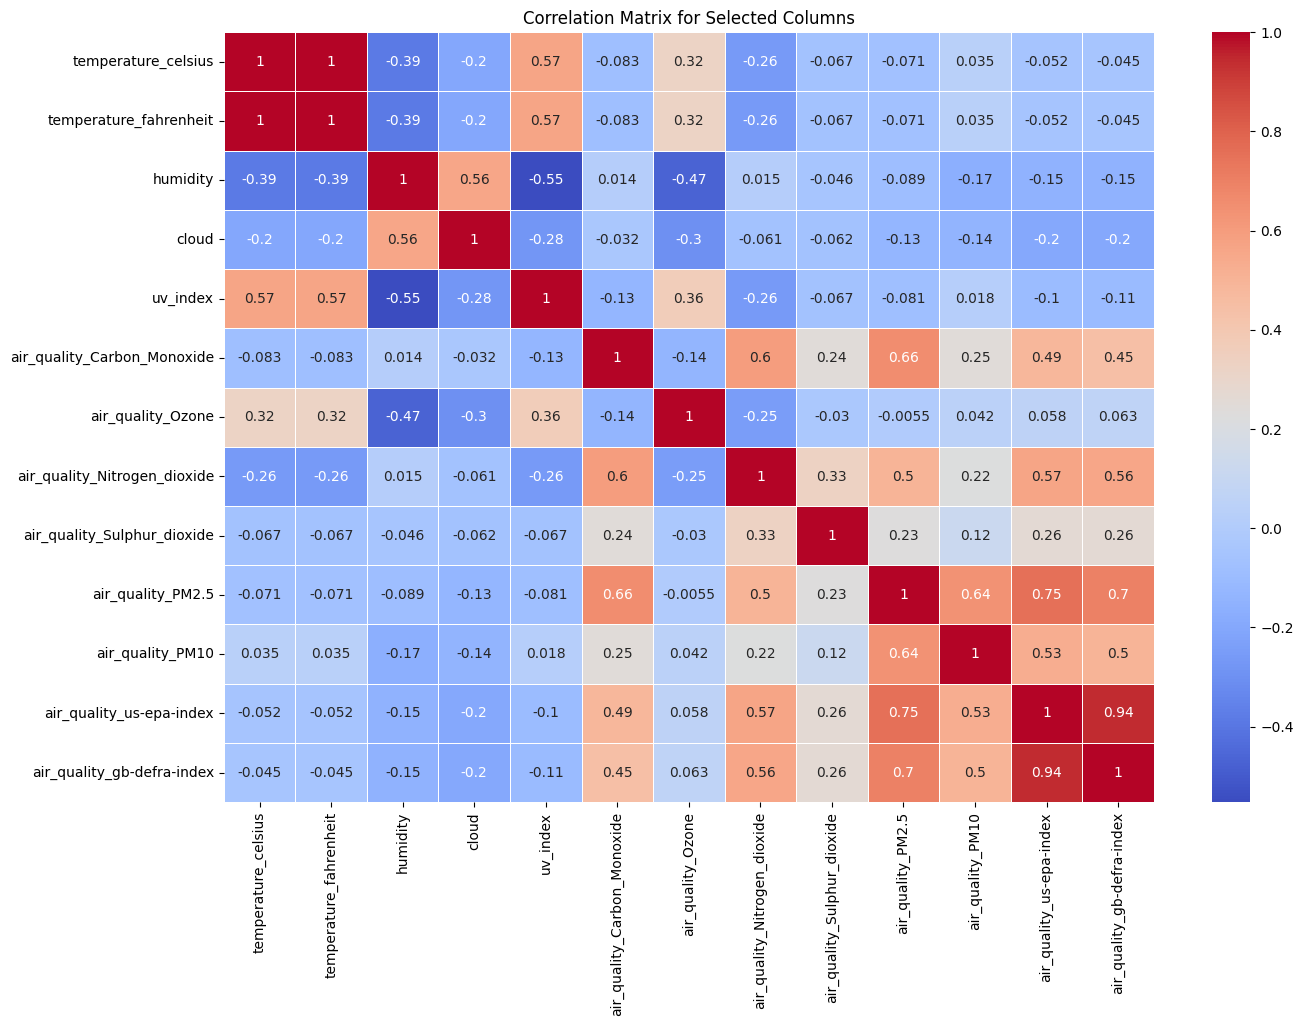

In [13]:
# Define the list of specific columns to visualize
selected_columns = [
    'temperature_celsius', 'temperature_fahrenheit', 'humidity', 'cloud',
    'uv_index', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5',
    'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index'
]

# Select only the specified columns from the dataset
specific_data = data[selected_columns]

# Drop columns that are completely missing or have no variation
specific_data = specific_data.dropna(axis=1, how='all')  # Drop columns with all NaN values
specific_data = specific_data.loc[:, specific_data.nunique() > 1]  # Drop columns with no variation

# Calculate the correlation matrix for the selected columns
correlation_matrix = specific_data.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Selected Columns')
plt.show()

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Define the list of specific columns to visualize
selected_columns = [
    'temperature_celsius', 'temperature_fahrenheit', 'humidity', 'cloud',
    'uv_index', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5',
    'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index'
]

# Define dropdowns
country_dropdown = widgets.Dropdown(
    options=data['country'].unique().tolist(),
    description='Country:',
    layout=widgets.Layout(width='300px')
)

location_dropdown = widgets.Dropdown(
    options=[],  # Dynamically populated based on country selection
    description='Location:',
    layout=widgets.Layout(width='300px')
)

# Define an output area for the heatmap
output = widgets.Output()

# Update location dropdown based on country selection
def update_location_dropdown(change):
    selected_country = change['new']
    locations = data[data['country'] == selected_country]['location_name'].unique().tolist()
    location_dropdown.options = locations

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')

# Function to plot the heatmap
def plot_heatmap(country, location):
    # Filter the data based on the selected country and location
    data_filtered = data[(data['country'] == country) & (data['location_name'] == location)]

    # Select only the specified columns
    specific_data = data_filtered[selected_columns]

    # Drop columns that are completely missing or have no variation
    specific_data = specific_data.dropna(axis=1, how='all')  # Drop columns with all NaN values
    specific_data = specific_data.loc[:, specific_data.nunique() > 1]  # Drop columns with no variation

    # Check if there is enough data for a correlation matrix
    if specific_data.empty or specific_data.shape[1] < 2:
        with output:
            output.clear_output()
            print("Not enough data to plot the heatmap.")
        return

    # Calculate the correlation matrix
    correlation_matrix = specific_data.corr()

    # Plot the heatmap
    with output:
        output.clear_output()
        plt.figure(figsize=(15, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title(f'Correlation Matrix for {country}, {location}')
        plt.show()

# Create a button for plotting the heatmap
plot_button = widgets.Button(
    description="Plot Heatmap",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the heatmap when the button is clicked
def on_plot_button_click(b):
    with output:
        output.clear_output(wait=True)
        plot_heatmap(country_dropdown.value, location_dropdown.value)

plot_button.on_click(on_plot_button_click)

# Display the controls and output
controls = widgets.VBox([country_dropdown, location_dropdown, plot_button])
display(widgets.HBox([controls, output]))


Number of samples in X: 47874
Number of labels in y: 47874
Feature Importance (CatBoost):
                         Feature  Importance
2                       uv_index   34.402345
5   air_quality_Nitrogen_dioxide   18.358746
4              air_quality_Ozone   11.746792
0                       humidity    9.270021
3    air_quality_Carbon_Monoxide    6.870882
1                          cloud    5.421135
8               air_quality_PM10    4.784584
6    air_quality_Sulphur_dioxide    4.280656
7              air_quality_PM2.5    3.464711
9       air_quality_us-epa-index    0.835513
10    air_quality_gb-defra-index    0.564615


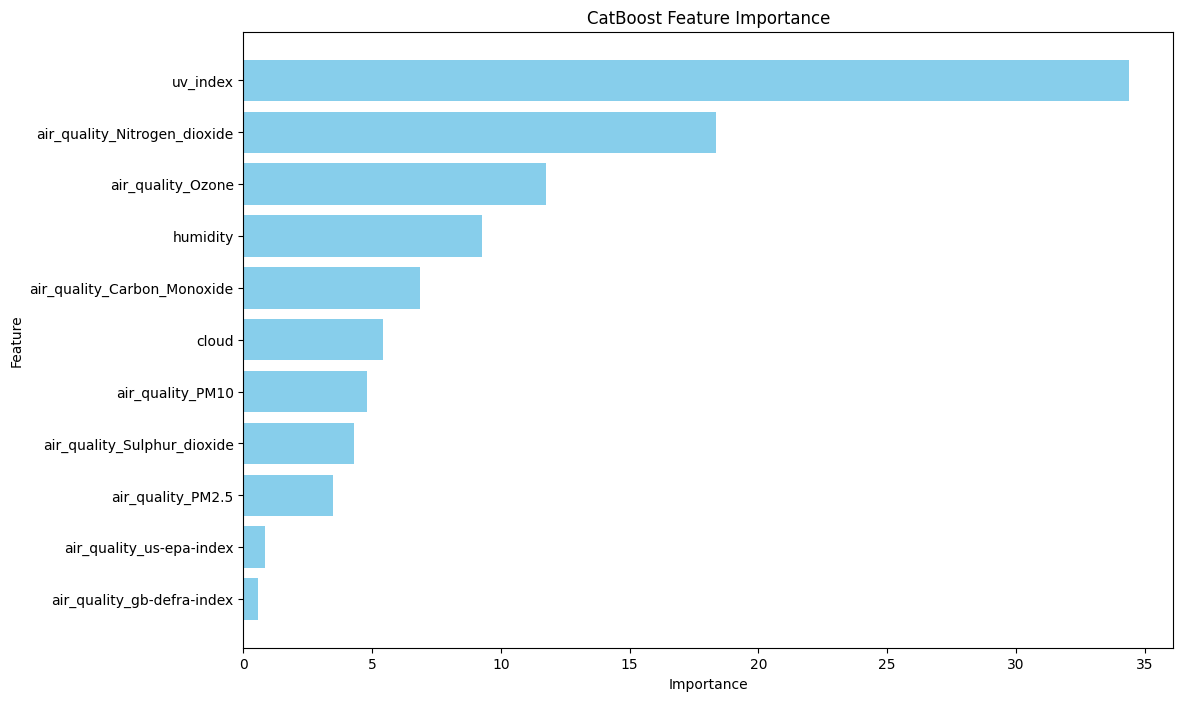

In [15]:
# Feature importance analysis using CatBoost
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool

# Define the target and features
target = 'temperature_celsius'  # Replace with your target variable
features = [
    'humidity', 'cloud', 'uv_index',
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
    'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
    'air_quality_us-epa-index', 'air_quality_gb-defra-index'
]

# Handle missing values consistently
X = data[features].dropna()  # Drop rows with missing feature values
y = data[target].dropna()    # Drop rows with missing target values

# Ensure indices match between X and y
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

# Check lengths to ensure alignment
print(f"Number of samples in X: {len(X)}")
print(f"Number of labels in y: {len(y)}")

# Define and train the CatBoost model
catboost_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    silent=True
)
catboost_model.fit(X, y)

# Get feature importance
feature_importances = catboost_model.get_feature_importance(Pool(X, y))
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
print("Feature Importance (CatBoost):")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()



SHAP Summary Plot:


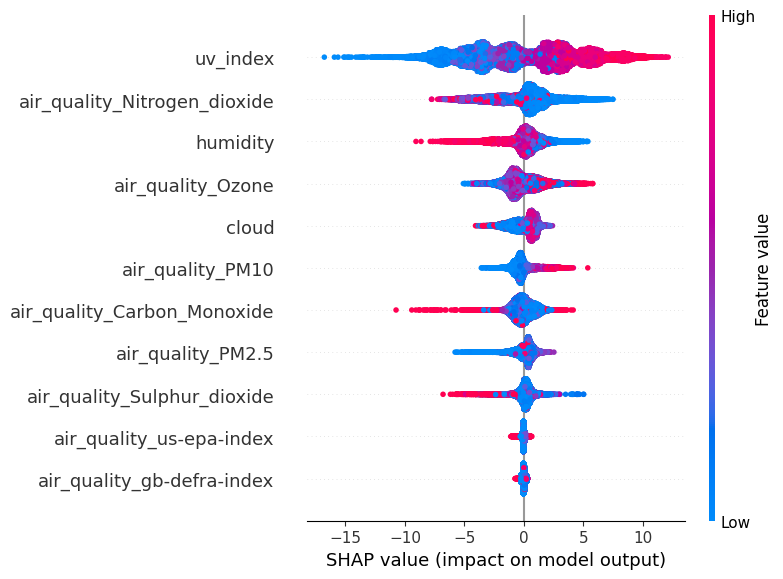

In [16]:
import shap
# Calculate SHAP values
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X)

# Plot SHAP summary plot
print("SHAP Summary Plot:")
shap.summary_plot(shap_values, X)

In [17]:
# !pip install geopandas folium shapely

In [18]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

# Inspect the data for required columns
print(data.head())

# Define columns for spatial analysis
latitude_col = 'latitude'
longitude_col = 'longitude'
attribute_col = 'temperature_celsius'  # Replace with the attribute to analyze


       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch        last_updated  temperature_celsius  \
0          1715849100 2024-05-16 13:15:00                 26.6   
1          1715849100 2024-05-16 10:45:00                 19.0   
2          1715849100 2024-05-16 09:45:00                 23.0   
3          1715849100 2024-05-16 10:45:00                  6.3   
4          1715849100 2024-05-16 09:45:00                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2  P

<Figure size 1200x800 with 0 Axes>

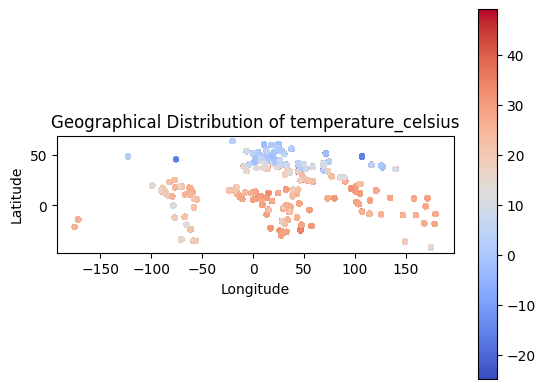

In [19]:
from shapely.geometry import Point

# Create a GeoDataFrame for spatial analysis
geometry = [Point(xy) for xy in zip(data[longitude_col], data[latitude_col])]
geo_df = gpd.GeoDataFrame(data, geometry=geometry)

# Plot geographical patterns
plt.figure(figsize=(12, 8))
geo_df.plot(column=attribute_col, cmap='coolwarm', legend=True, markersize=10)
plt.title(f'Geographical Distribution of {attribute_col}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
